In [479]:
import pandas as pd
import numpy as np
import tensorflow as tf
from data_loader import load_veterans_ds, prepare_veterans_ds, load_cancer_ds, prepare_cancer_ds
from sklearn.preprocessing import StandardScaler
from utility import InputFunction, CindexMetric, CoxPHLoss, _make_riskset, _TFColor, sample_hmc, convert_to_structured
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import pickle
from sksurv.metrics import integrated_brier_score

TFColor = _TFColor()
dtype = tf.float32
number_burnin_steps = 10000

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# Load data
X_train, X_valid, X_test, y_train, y_valid, y_test = load_veterans_ds()
t_train, t_valid, t_test, e_train, e_valid, e_test  = prepare_veterans_ds(y_train, y_valid, y_test)

# Load model chains
curr_dir = os.getcwd()
root_dir = Path(curr_dir).absolute().parent
with open(f'{root_dir}/models/mcmc_chains.pkl', 'rb') as fp:
    chains = pickle.load(fp)
    
# Make structured arrays
y_train_struc = convert_to_structured(t_train, e_train)
y_valid_struc = convert_to_structured(t_valid, e_valid)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


In [480]:
# Save alpha and betas from chain at index 0
chain_index = 0
alpha_index = 0
beta_index = 1

samples = chains[chain_index]
alphas = samples.all_states[alpha_index].numpy().flatten()[number_burnin_steps:] # skip burnin steps
n_dims = chains[chain_index].all_states[beta_index].shape[2]
number_of_steps = chains[chain_index].all_states[beta_index].shape[0]

X_train = np.array(X_train)[:,:n_dims]
X_valid = np.array(X_valid)[:,:n_dims]
X_test = np.array(X_test)[:,:n_dims]

# Scale
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_valid = scaler.transform(X_valid)
#X_test = scaler.transform(X_test)
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

betas = np.zeros((n_dims, number_of_steps-number_burnin_steps))
for i in range(n_dims):
    betas[i] = samples.all_states[beta_index][:,:,i].numpy().flatten()[number_burnin_steps:]

print(alphas.mean())
for beta in betas:
    print(beta.mean())

4.80522
0.00191976543786202
0.2502355286087877
-0.6964838382139802
0.8789880781121552
0.004413171131340641
0.004861470363051012
0.4465033402923262
0.3259398818740672


In [481]:
np.exp(alphas.mean())

122.14637

In [482]:
lambda_mean, lambda_std = np.exp(alphas.mean()), np.exp(alphas.std())
mean_obs_time = y_train[y_train['Status']==False]['Survival_in_days'].mean()
print(f"mean/std lambda: {np.around(float(lambda_mean), 2)} (+-{np.around(float(lambda_std), 2)})")
print(f"mean obs time: {mean_obs_time}")

mean/std lambda: 122.15 (+-1.06)
mean obs time: 131.28571428571428


In [483]:
mean_alpha = alphas.mean()
mean_betas = betas.mean(axis=1)

np.exp(mean_alpha + X_valid @ mean_betas)

array([ 92.15910523, 660.82659156, 240.10190024, 132.90365095,
       244.88901172, 125.51518007, 273.90275318,  77.52123628,
       434.8160822 , 549.37902012, 375.06734529, 269.36826084,
       203.81015925, 149.76025339,  97.42601684, 155.81733999,
       562.29618269,  96.03220468, 573.88685493, 689.57942777,
        91.85362754])

In [484]:
# Make predictions on valid dataset (ignore the uncertainity)
mean_alpha = tf.math.reduce_mean(alphas, axis=0).numpy()
mean_betas = tf.math.reduce_mean(betas, axis=1).numpy()

predict_func = lambda data: np.exp(mean_alpha + np.dot(mean_betas, np.transpose(data)))

valid_preds = np.zeros((len(X_valid)))
for i, data in enumerate(X_valid):
    valid_preds[i] = predict_func(data)

In [485]:
print(t_valid)

[ 22.  30.  19.  61. 156.  24.  12.  18. 314. 110. 177.  36.   2. 153.
  31.  54.   1. 117. 340. 389. 151.]


In [486]:
print([round(float(pred)) for pred in valid_preds])

[92, 661, 240, 133, 245, 126, 274, 78, 435, 549, 375, 269, 204, 150, 97, 156, 562, 96, 574, 690, 92]


In [487]:
# Calculate C-index using negative event times as risk
from sksurv.metrics import concordance_index_censored
results = concordance_index_censored(e_valid, t_valid, -valid_preds)[0]
print(results)

0.6047619047619047


In [488]:
# Calculate Brier score
lower, upper = np.percentile(t_valid[t_valid.dtype.names], [10, 90])
times = np.arange(lower, upper+1)

estimate = np.zeros((len(X_valid), len(times)))
for i, data_obs in enumerate(X_valid):
    pred_lambda = predict_func(data)
    surv_prob = np.exp(-times/pred_lambda)
    estimate[i] = surv_prob

integrated_brier_score(y_train_struc, y_valid_struc, estimate, times)

0.2028143825304295

Text(0, 0.5, 'Density')

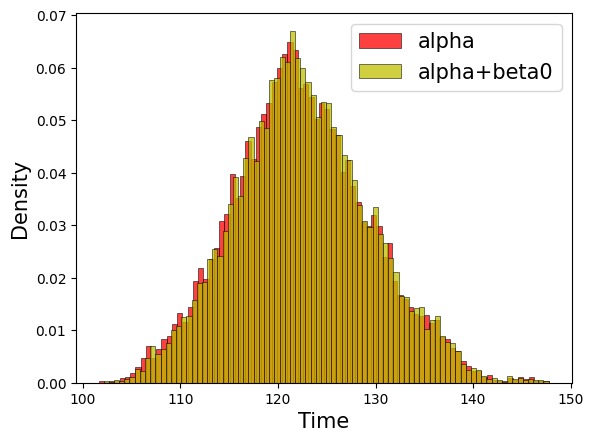

In [489]:
# Calculate log rate as log lambda = a+bX 
lambda_no_beta = np.exp(alphas)
lambda_beta0 = np.exp(alphas + betas[0])
#lambda_beta1 = np.exp(alphas + betas[1])
#lambda_beta2 = np.exp(alphas + betas[2])

# Plot distributions with various betas used. Notice the shift in risk (normalized)
sns.histplot(lambda_no_beta, color='r', stat='density', label='alpha')
sns.histplot(lambda_beta0, color='y', stat='density', label='alpha+beta0')
#sns.histplot(lambda_beta1, color='b', stat='density', label='alpha+beta1')
#sns.histplot(lambda_beta2, color='m', stat='density', label='alpha+beta2')
plt.legend(fontsize=15)
plt.xlabel("Time", size=15)
plt.ylabel("Density", size=15)

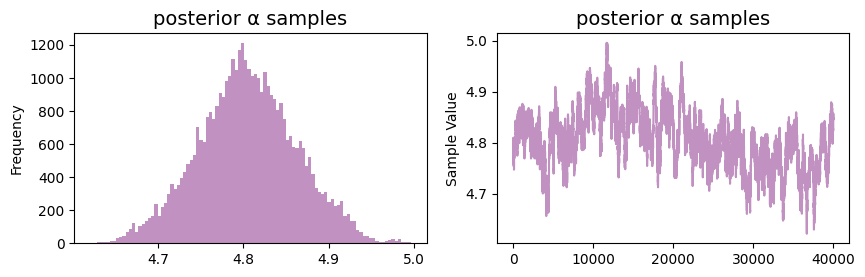

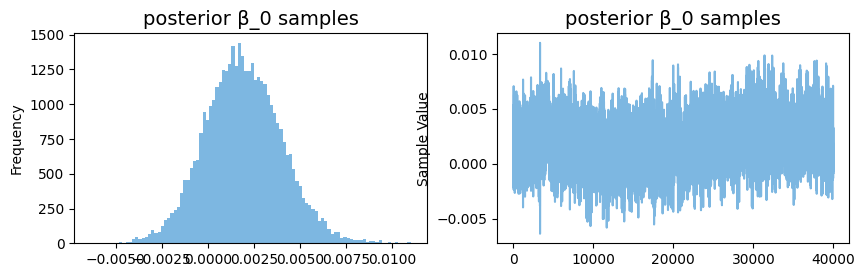

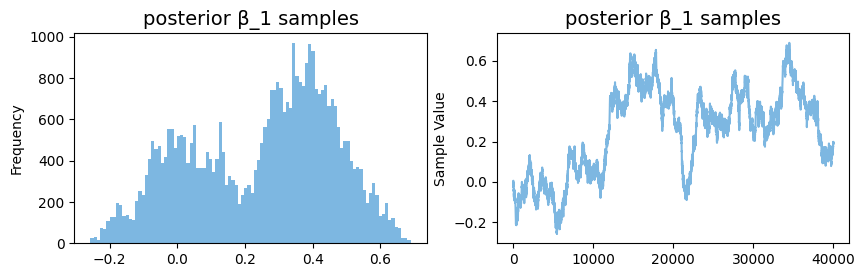

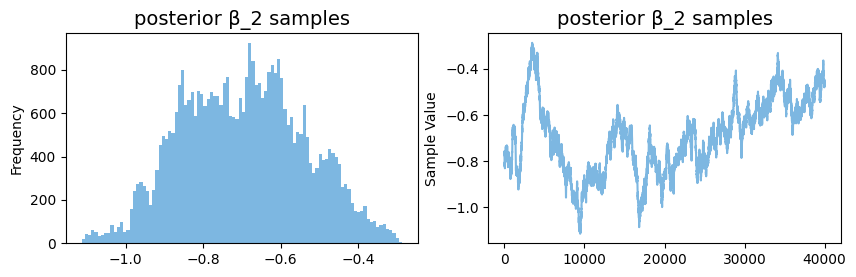

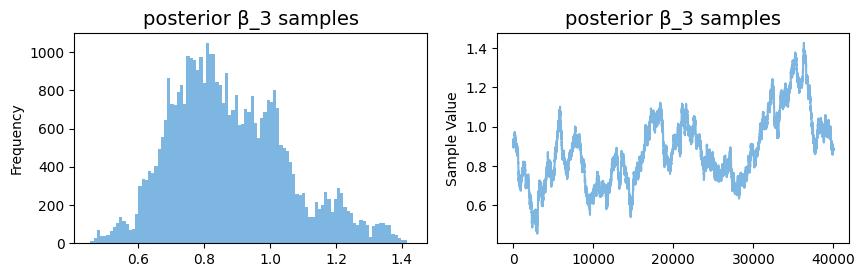

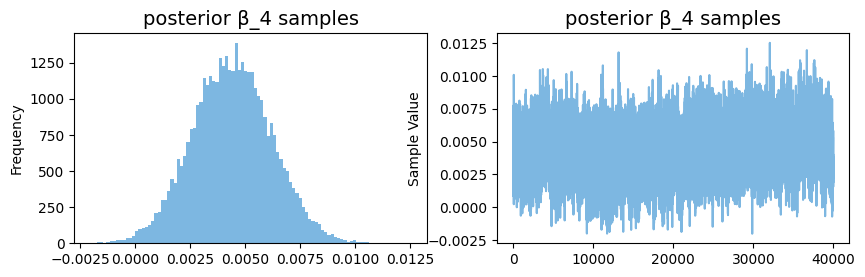

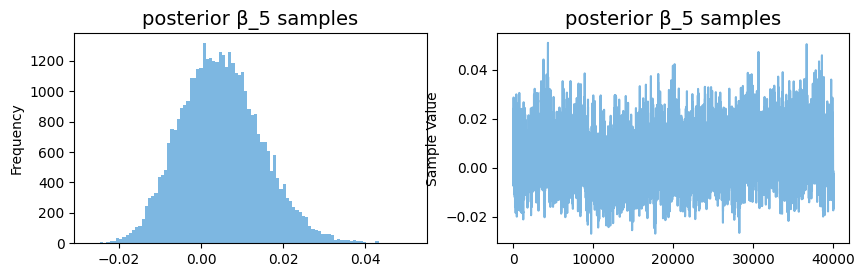

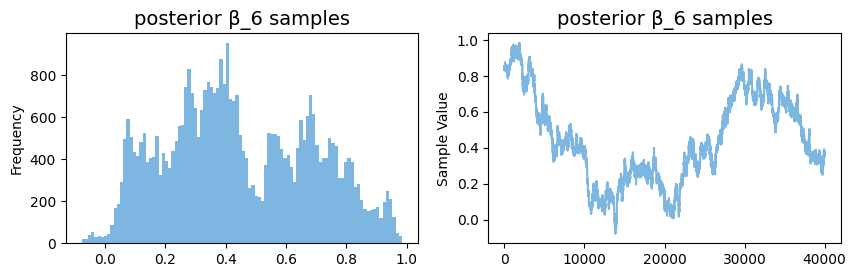

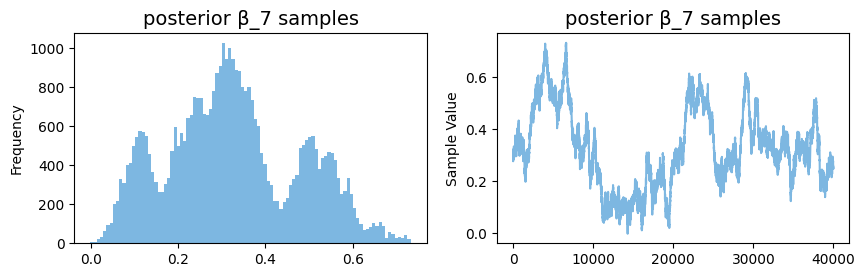

In [490]:
# Plot the posterior samples
 
plt.figure(figsize=(10,6))
plt.subplot(2, 2, 1)
plt.hist(alphas, bins=100, color=TFColor[6], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior α samples', fontsize=14)

plt.subplot(2, 2, 2)
plt.plot(np.arange(number_of_steps-number_burnin_steps), alphas, color=TFColor[6], alpha=0.8)
plt.ylabel('Sample Value')
plt.title('posterior α samples', fontsize=14)

for i in range(n_dims):
    plt.figure(figsize=(10,6))
    plt.subplot(2, 2, 1)
    plt.hist(betas[i], bins=100, color=TFColor[3], alpha=0.8)
    plt.ylabel('Frequency')
    plt.title(f'posterior β_{i} samples', fontsize=14)

    plt.subplot(2, 2, 2)
    plt.plot(np.arange(number_of_steps-number_burnin_steps), betas[i], color=TFColor[3], alpha=0.8)
    plt.ylabel('Sample Value')
    plt.title(f'posterior β_{i} samples', fontsize=14)

In [491]:
chains_t = list(map(list, zip(*chains)))
chains_samples = [tf.squeeze(tf.concat(samples[0], axis=0)) for samples in chains_t[0]] + \
                 [tf.squeeze(tf.concat(samples[1], axis=0)) for samples in chains_t[0]]

In [492]:
chains_samples

[<tf.Tensor: shape=(50000,), dtype=float32, numpy=
 array([4.7407937, 4.7388387, 4.7439733, ..., 4.84484  , 4.848545 ,
        4.848545 ], dtype=float32)>,
 <tf.Tensor: shape=(50000, 8), dtype=float32, numpy=
 array([[ 0.004088  ,  0.2927539 , -0.7158092 , ..., -0.00126516,
          0.7758969 ,  0.02188507],
        [ 0.00102868,  0.29270622, -0.7138884 , ..., -0.00335477,
          0.7652212 ,  0.02877758],
        [ 0.00454581,  0.3069147 , -0.7140529 , ...,  0.00448224,
          0.7600515 ,  0.02756861],
        ...,
        [ 0.00277447,  0.18977953, -0.46745113, ..., -0.00236261,
          0.36435392,  0.2490639 ],
        [-0.00083616,  0.19540131, -0.4713963 , ..., -0.00576269,
          0.3725509 ,  0.25045976],
        [-0.00083616,  0.19540131, -0.4713963 , ..., -0.00576269,
          0.3725509 ,  0.25045976]], dtype=float32)>]

In [493]:
chains_df = pd.concat(
    objs=[pd.DataFrame(samples.numpy()) for samples in chains_samples], 
    axis=1
)

params = ['alpha'] + [f'beta_{i}' for i in range(n_dims)]
chains_df.columns = params

chains_df = chains_df \
    .assign(
        sample_id=lambda x: range(x.shape[0]), 
        chain_sample_id=lambda x: x['sample_id'] % number_of_steps,
        chain_id=lambda x: (x['sample_id'] / number_of_steps).astype(int) + 1
    ) \
    .assign(chain_id=lambda x: 'c_' + x['chain_id'].astype(str)) \
    

chains_df.head()

,alpha,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,sample_id,chain_sample_id,chain_id
0,4.740794,0.004088,0.292754,-0.715809,0.790224,0.004802,-0.001265,0.775897,0.021885,0,0,c_1
1,4.738839,0.001029,0.292706,-0.713888,0.793744,0.002859,-0.003355,0.765221,0.028778,1,1,c_1
2,4.743973,0.004546,0.306915,-0.714053,0.789622,0.007099,0.004482,0.760051,0.027569,2,2,c_1
3,4.730695,0.003711,0.299513,-0.716147,0.793981,0.003449,0.011128,0.756651,0.037219,3,3,c_1
4,4.737067,0.004102,0.300318,-0.716508,0.788724,0.006789,0.015071,0.765400,0.034917,4,4,c_1


Text(0.5, 1.03, 'Posterior Samples per Chain')

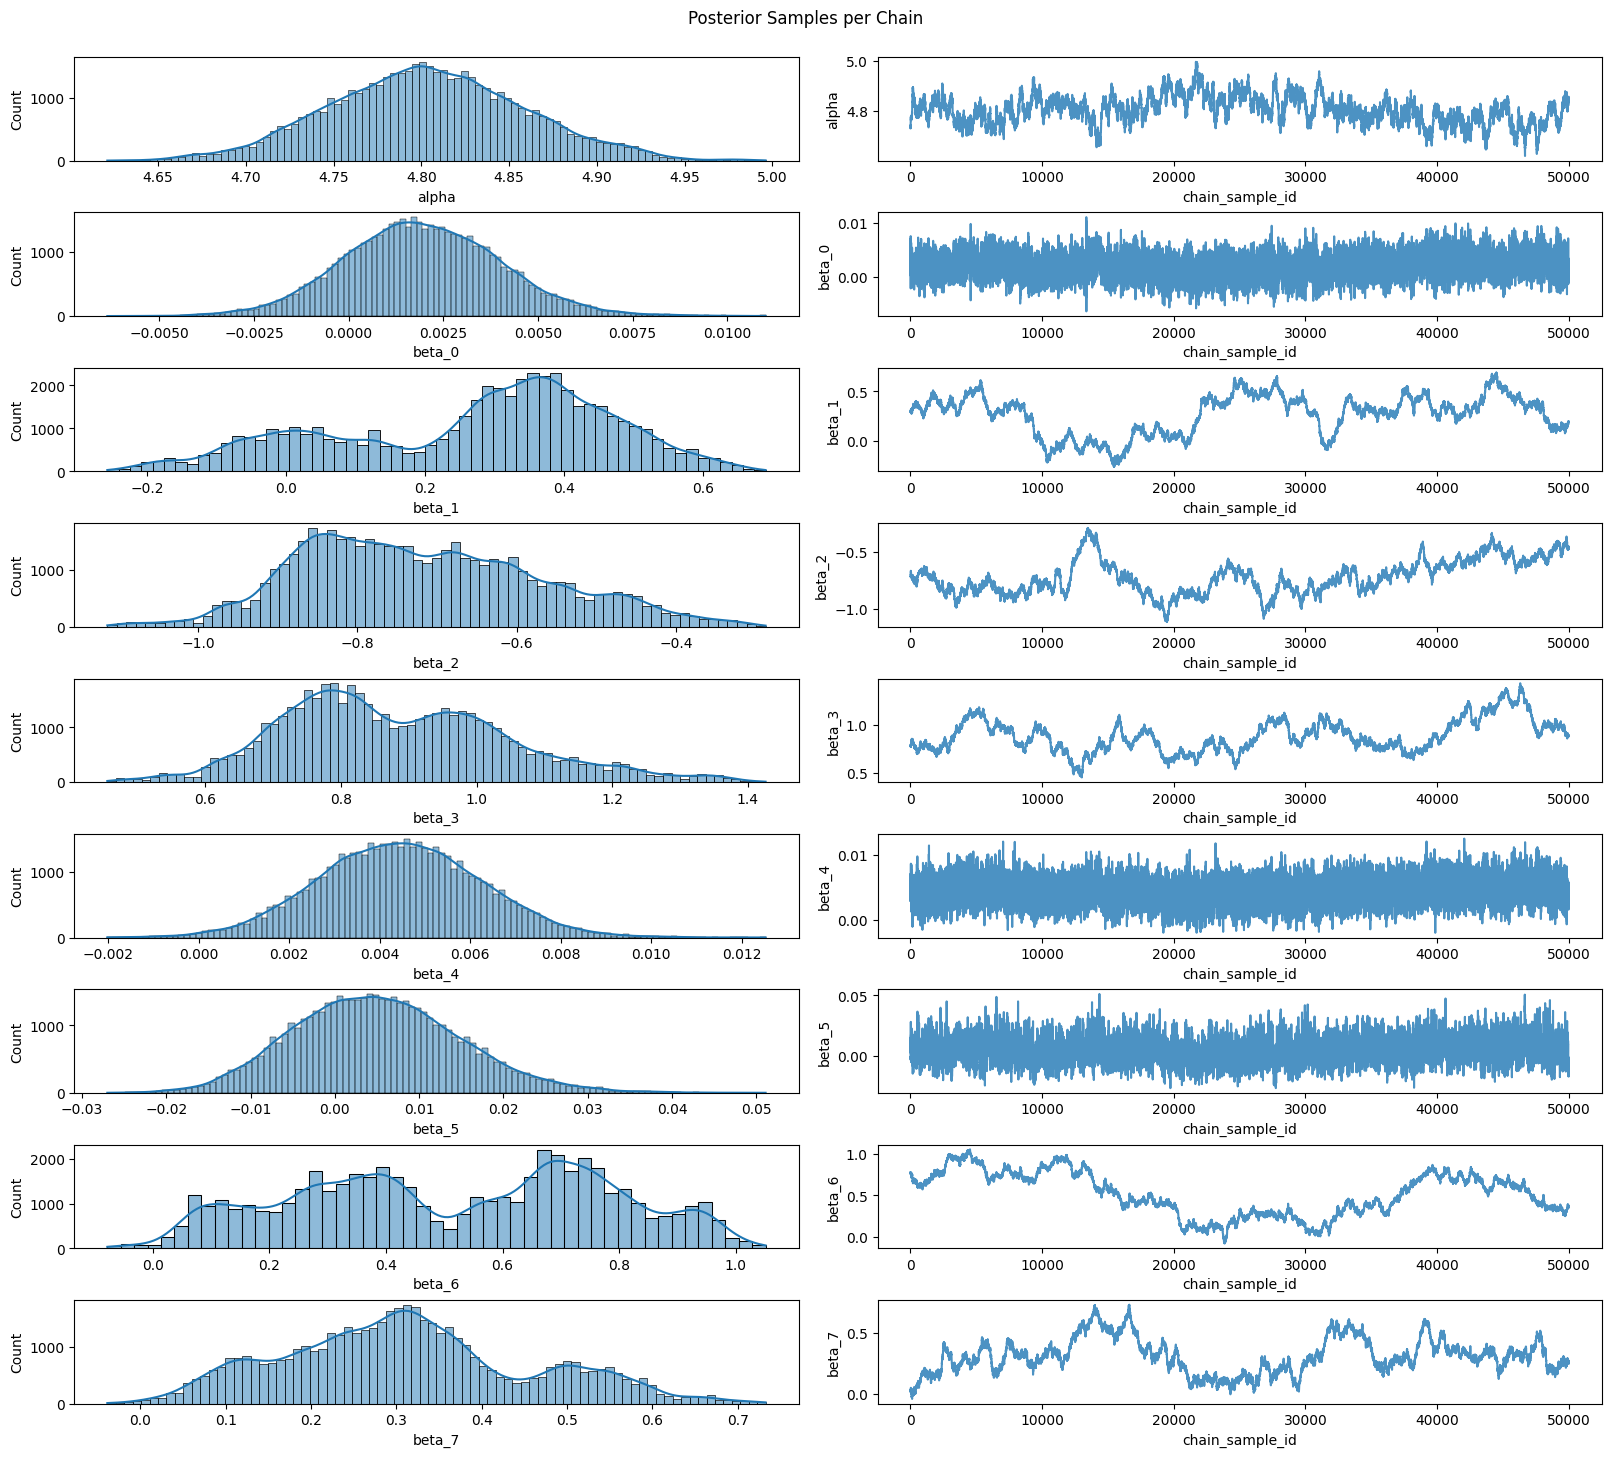

In [494]:
fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(16, 14), constrained_layout=True)

for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0], legend=False)
    sns.lineplot(x='chain_sample_id', y=param, data=chains_df, hue='chain_id', alpha=0.8, legend=False, ax=axes[i][1])

fig.suptitle('Posterior Samples per Chain', y=1.03)

Text(0.5, 1.03, 'Posterior Samples')

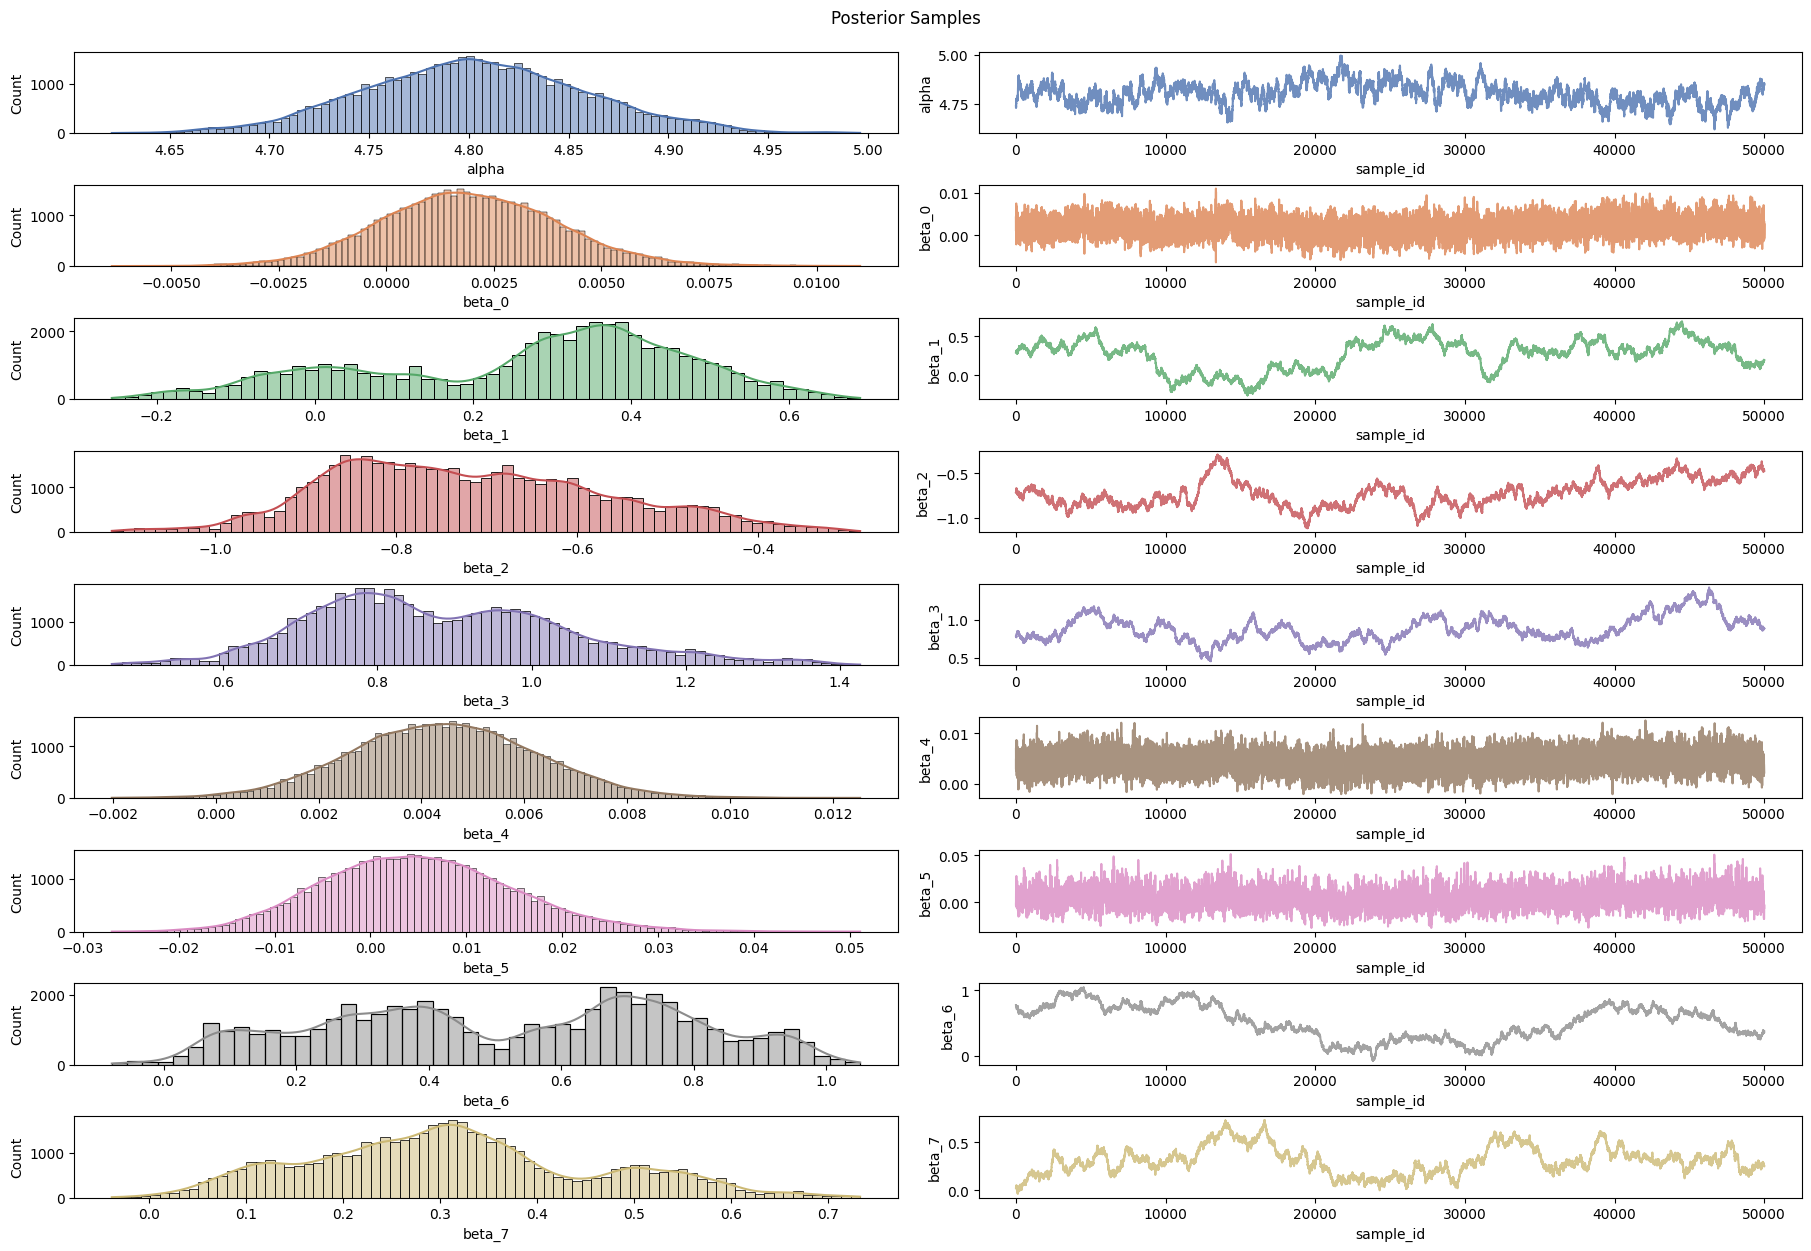

In [495]:
sns_c = sns.color_palette(palette='deep')

fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(18, 12), constrained_layout=True)

for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, color=sns_c[i], kde=True, ax=axes[i][0])
    sns.lineplot(x='sample_id', y=param, data=chains_df, color=sns_c[i], alpha=0.8, ax=axes[i][1])

fig.suptitle('Posterior Samples', y=1.03)

In [496]:
size = 100
x0 = np.random.randn(size)
x1 = np.random.randn(size)
x = np.stack([x0], axis=1)
x = tf.convert_to_tensor(x, dtype=dtype)

In [497]:
# Here we compute mu = alpha + beta x. #TODO: Needs to fit surv analysis exp(alpha +beta*x)
mu_posterior_samples = tf.linalg.matmul(tf.reshape(chains_samples[0], (-1, 1)), tf.ones(shape=(1, x_obs.shape[0]))) \
    + tf.linalg.matmul(tf.reshape(chains_samples[1], (-1, 1)), tf.transpose(x_obs))

NameError: name 'x_obs' is not defined

In [ ]:
mu_posterior_mean = tf.math.reduce_mean(mu_posterior_samples, axis=0).numpy()
mu_posterior_std = tf.math.reduce_std(mu_posterior_samples, axis=0).numpy()

NameError: name 'mu_posterior_samples' is not defined

In [ ]:
random_guess = tf.convert_to_tensor(np.random.uniform(0, 10, size=(len(y_preds), 1)).astype(np.float32))

NameError: name 'y_preds' is not defined

In [ ]:
train_event_set = tf.expand_dims(e_train.astype(np.int32), axis=1)
train_risks_set = tf.convert_to_tensor(_make_riskset(t_train))
y_pred = tf.convert_to_tensor(y_preds.reshape(len(y_preds), 1).astype(np.float32))

NameError: name 'y_preds' is not defined

In [ ]:
mcmc_train_loss = loss_fn(y_true=[train_event_set, train_risks_set], y_pred=y_pred)
random_guess_loss = loss_fn(y_true=[train_event_set, train_risks_set], y_pred=random_guess)
print(f"MCMC loss {mcmc_train_loss}, random: {random_guess_loss}")